In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import set_global_seed
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.pytorch.normalization import *
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
set_global_seed(42)

# data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
data_paths = [DATA_PATH / "prp2/stage_data_250hz_t1.nc", DATA_PATH / "prp2/stage_data_250hz_t2.nc"]
# 80/20 train/val (no test)
splits = split_participants_custom(data_paths, 0.15)
# Labels per dataset (same order as data_paths)
data_labels = [["negative", "t1_1", "t1_2", "t1_3", "t1_4"], ["negative", "t2_1", "t2_2", "t2_3", "t2_4"]]
# Labels combined
labels = ["negative", "t1_1", "t1_2", "t1_3", "t1_4", "t2_1", "t2_2", "t2_3", "t2_4"]

info_to_keep = ["task", "RT1korr", "WortRTkorr"]
subset_cond = ('SOA', 'equal', 'lang')
add_negative = True
skip_samples = 0 # 62
cut_samples = 0 # 63
add_pe = True

In [3]:
norm_fn = norm_mad_zscore
train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    labels=labels,
    data_labels=data_labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    transform=Compose([StartJitterTransform(50, 1.0), EndJitterTransform(50, 1.0)]),
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics["class_weights"]
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    labels=labels,
    data_labels=data_labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)

In [4]:
config = {
    "n_channels": 60,
    "n_classes": len(labels),
    "n_mamba_layers": 5,
    "use_pointconv_fe": True,
    "spatial_feature_dim": 128,
    "use_conv": True,
    "conv_kernel_sizes": [3, 9],
    "conv_in_channels": [128, 128],
    "conv_out_channels": [256, 256],
    "conv_concat": True,
    "use_pos_enc": add_pe,
}
model = build_mamba(config)
train_and_test(
    model,
    train_data,
    None,
    val_data,
    logs_path=Path("../logs/"),
    workers=12,
    batch_size=32,
    lr=0.00005,
    epochs=40,
)

  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 0: LR = 0.000050


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 1: LR = 0.000050


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 2: LR = 0.000049


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 3: LR = 0.000049


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 4: LR = 0.000048


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 5: LR = 0.000047


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 6: LR = 0.000046


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 7: LR = 0.000045


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 8: LR = 0.000044


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 9: LR = 0.000043


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 10: LR = 0.000041


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 11: LR = 0.000040


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 12: LR = 0.000038


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 13: LR = 0.000036


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 14: LR = 0.000035


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 15: LR = 0.000033


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 16: LR = 0.000031


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 17: LR = 0.000029


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 18: LR = 0.000027


  0%|          | 0/224 [00:00<?, ? batch/s]

Epoch 19: LR = 0.000025


  0%|          | 0/224 [00:00<?, ? batch/s]

In [ ]:
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model

chk_path = Path("../models/prp_final.pt")
checkpoint = load_model(chk_path)
config = {
    "n_channels": 60,
    "n_classes": len(labels),
    "n_mamba_layers": 5,
    "use_pointconv_fe": True,
    "spatial_feature_dim": 128,
    "use_conv": True,
    "conv_kernel_sizes": [3, 9],
    "conv_in_channels": [128, 128],
    "conv_out_channels": [256, 256],
    "conv_concat": True,
    "use_pos_enc": add_pe,
}

model = build_mamba(config)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

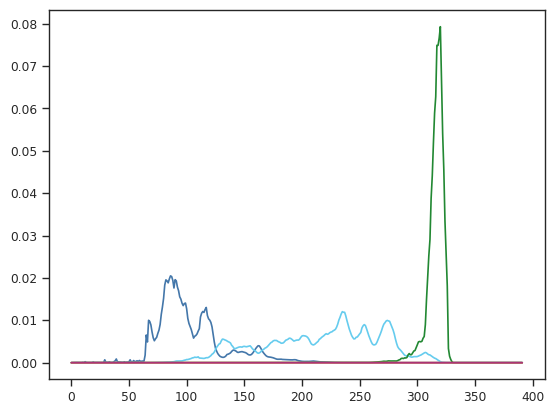

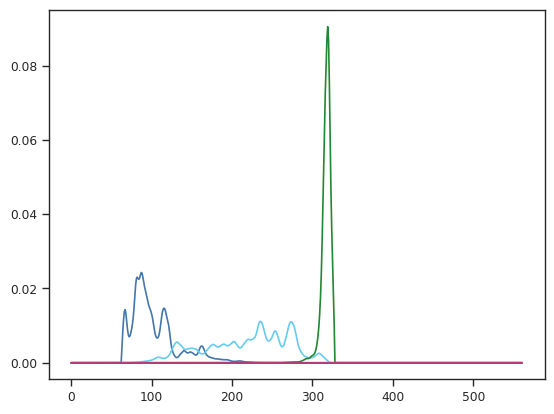

In [8]:
from hmpai.pytorch.utilities import TASKS
idx = 4
item = val_data.__getitem__(idx)
data = item[0].unsqueeze(0).to('cuda')
pred = model(data, task=[item[2][0]['task']])
pred = torch.nn.Softmax(dim=2)(pred).cpu().detach().numpy().squeeze()
true = item[1]

import matplotlib.pyplot as plt
from hmpai.visualization import set_seaborn_style
set_seaborn_style()
for i in range(pred.shape[1]):
    if i == 0:
        continue
    plt.plot(pred[:, i])
plt.show()

for i in range((true.shape[1])):
    if i == 0:
        continue
    plt.plot(true[:, i])
plt.show()